In [14]:
import datetime as dt

In [15]:

import numpy as np
import pandas as pd
import scipy.stats as stats

import pyomo.environ as pyo

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [16]:
import yfinance as yf

### Solver

In [17]:
solver = 'appsi_highs'
SOLVER = pyo.SolverFactory(solver)
assert SOLVER.available(), f"Solver {solver} is not available."

## Data

### Download Data

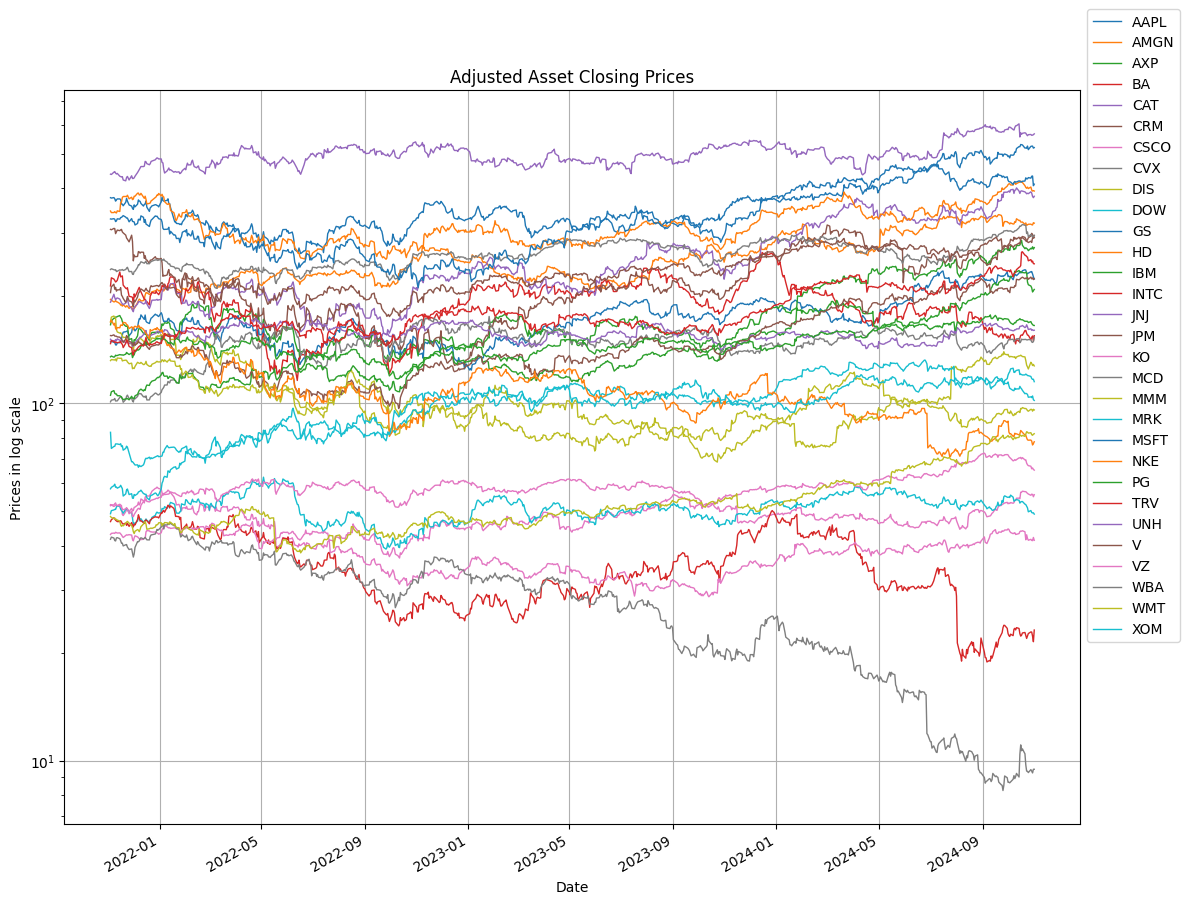

In [5]:
tickers = [
    "AXP",
    "AAPL",
    "AMGN",
    "BA",
    "CAT",
    "CRM",
    "CSCO",
    "CVX",
    "DIS",
    "DOW",
    "GS",
    "HD",
    "IBM",
    "INTC",
    "JNJ",
    "JPM",
    "KO",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "V",
    "VZ",
    "WBA",
    "WMT",
    "XOM",
]

n_years = 3.0
end_date = dt.date.today()
start_date = end_date - dt.timedelta(round(n_years * 365))

assets = yf.download(tickers, start=start_date, end=end_date, progress=False)[
    "Adj Close"
].bfill().ffill()

fig, ax = plt.subplots(figsize=(12, 9))
assets.plot(ax=ax, logy=True, grid=True, lw=1, title="Adjusted Asset Closing Prices")
ax.legend(bbox_to_anchor=(1.0, 1.12))
ax.set_ylabel("Prices in log scale")
plt.tight_layout()
plt.show()

#### Scaled Asset Prices

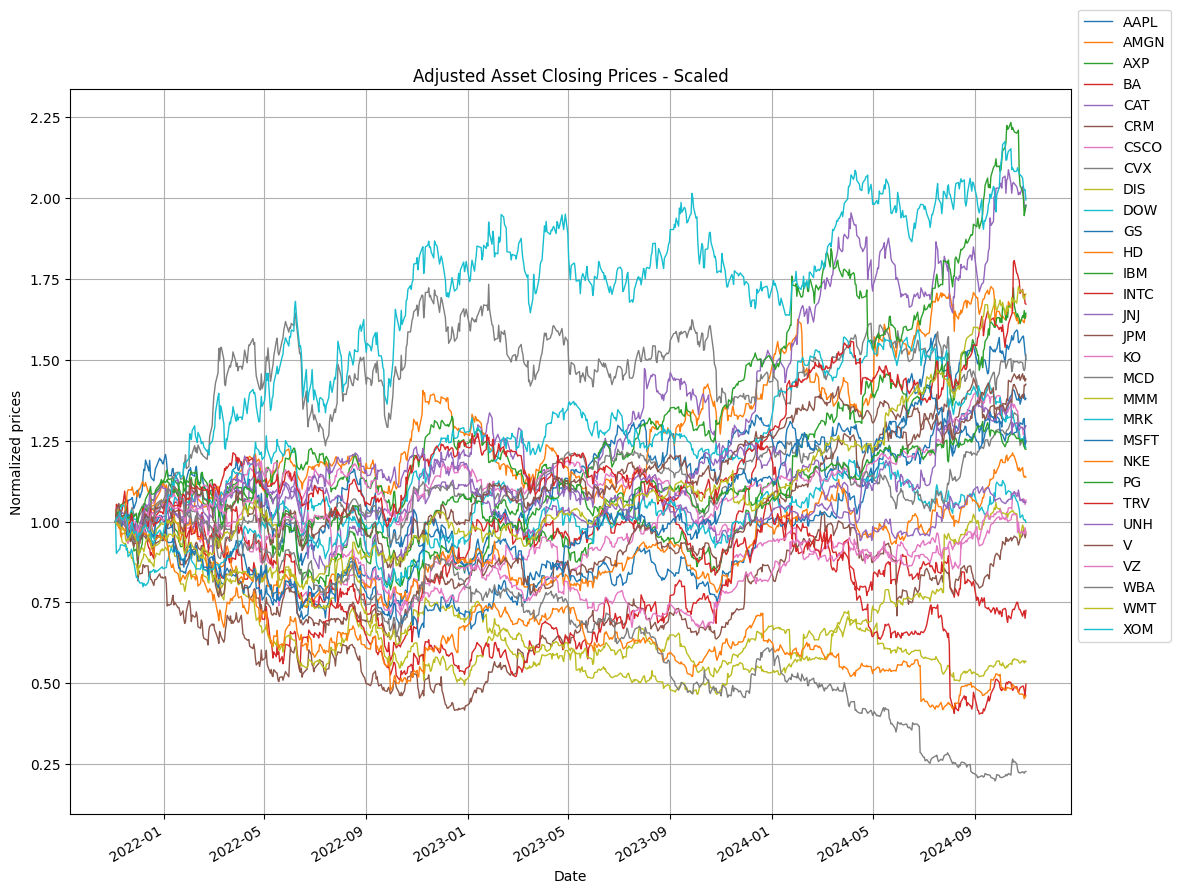

In [6]:
assets_scaled = assets.div(assets.iloc[0])

fig, ax = plt.subplots(figsize=(12, 9))
assets_scaled.plot(
    ax=ax, grid=True, lw=1, title="Adjusted Asset Closing Prices - Scaled"
)
ax.legend(bbox_to_anchor=(1.0, 1.12))
ax.set_ylabel("Normalized prices")
plt.rcParams["font.size"] = 13
plt.tight_layout()
plt.show()

#### Daily Returns

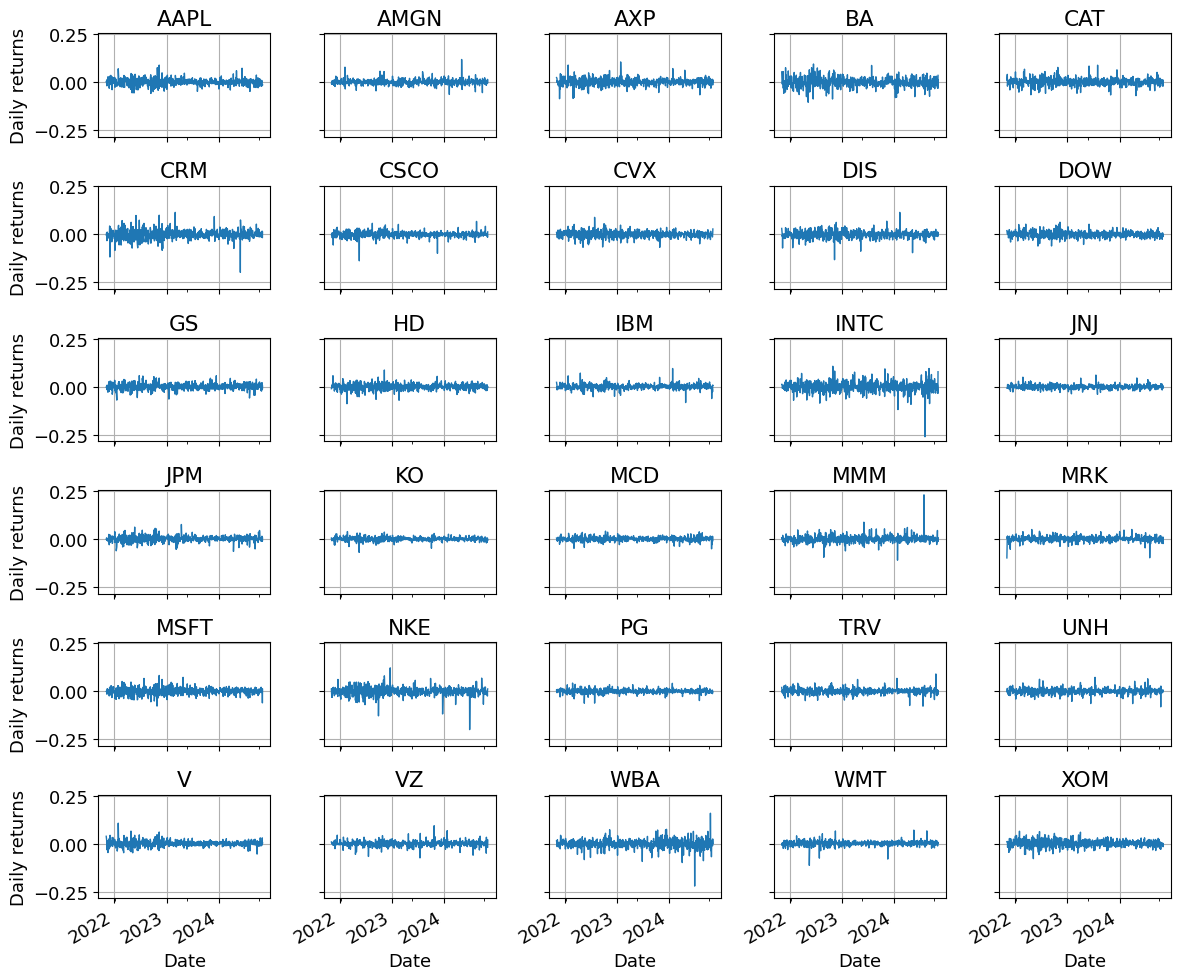

In [7]:
daily_returns = assets.diff()[1:] / assets.shift(1)[1:]

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)

for a, s in zip(ax.flatten(), sorted(daily_returns.columns)):
    daily_returns[s].plot(ax=a, lw=1, title=s, grid=True)
    a.xaxis.set_major_locator(mdates.YearLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    a.set_ylabel("Daily returns")

plt.tight_layout()
plt.show()

#### Mean Absolute Deviation

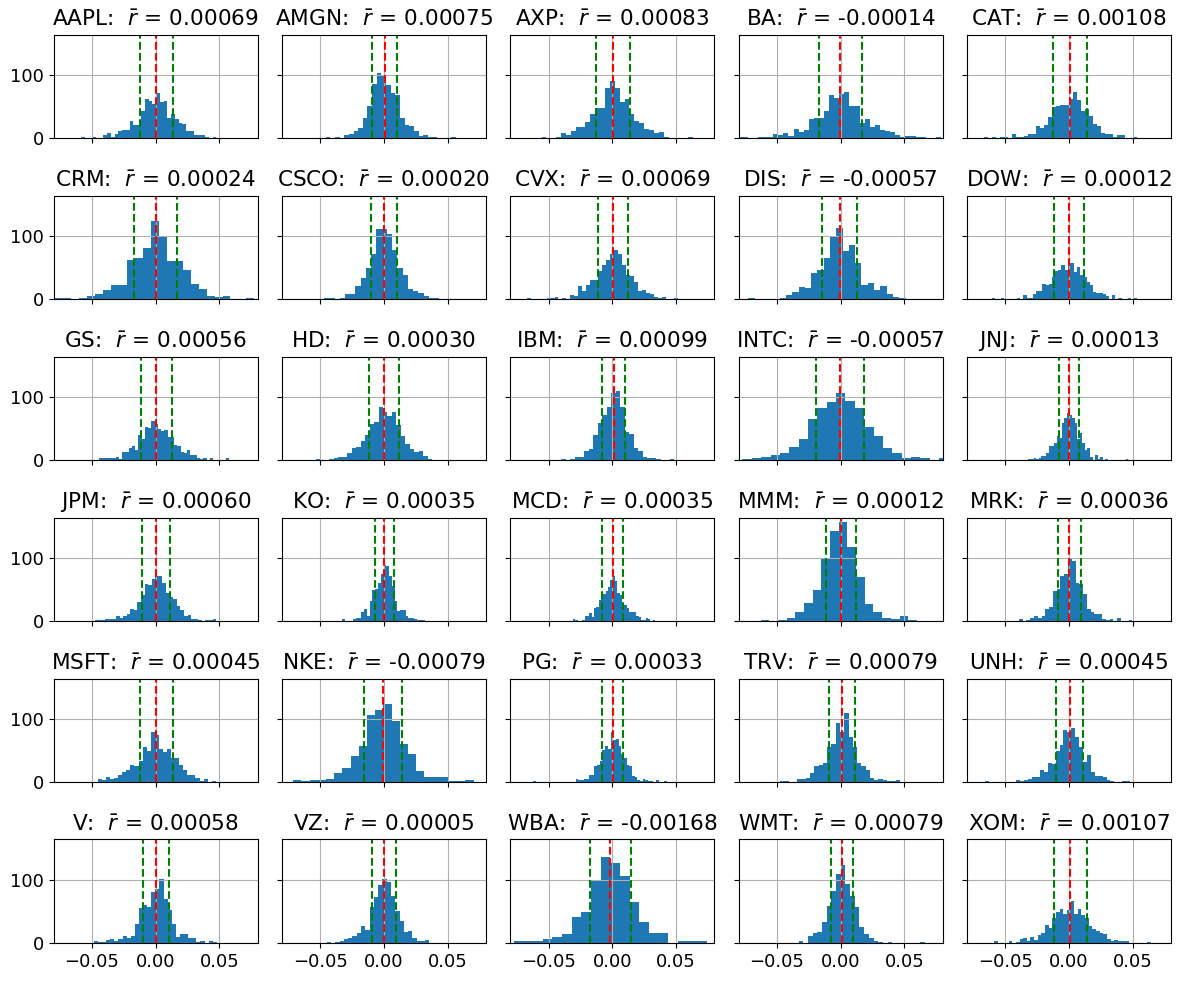

In [8]:
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

for a, s in zip(ax.flatten(), daily_returns.columns):
    daily_returns[s].hist(ax=a, lw=1, grid=True, bins=50)
    a.set_title(f"{s}:  $\\bar r$ = {mean_return[s]:0.5f}")
    a.set_xlim(-0.08, 0.08)
    a.axvline(mean_return[s], color="r", linestyle="--")
    a.axvline(mean_return[s] + mean_absolute_deviation[s], color="g", linestyle="--")
    a.axvline(mean_return[s] - mean_absolute_deviation[s], color="g", linestyle="--")

plt.tight_layout()
plt.show()

#### Risk Return

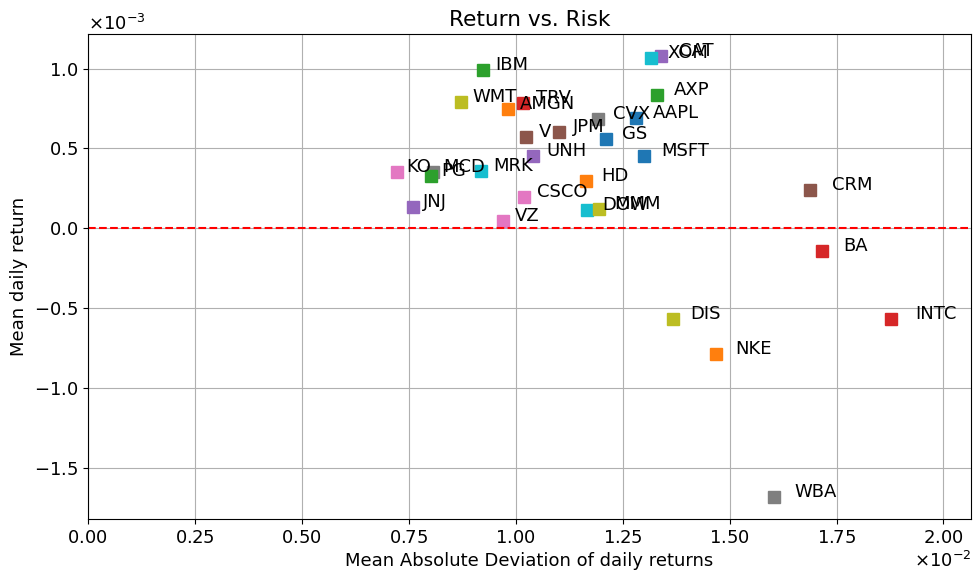

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
    ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

formatterx = mpl.ticker.ScalarFormatter(useMathText=True)
formatterx.set_scientific(True)
formatterx.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatterx)
formattery = mpl.ticker.ScalarFormatter(useMathText=True)
formattery.set_scientific(True)
formattery.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formattery)

ax.set_xlim(0, 1.1 * mean_absolute_deviation.max())
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Return vs. Risk")
ax.set_xlabel("Mean Absolute Deviation of daily returns")
ax.set_ylabel("Mean daily return")
ax.grid(True)
plt.tight_layout()
plt.show()

## Model

$$
\begin{align*}
    \min \quad & \frac{1}{T} \sum_{t=1}^T (u_t + v_t) \\
    \text{s.t.} \quad 
    & u_t - v_t  = \sum_{j=1}^J w_j(r_{t,j} - \bar{r}_j) & \forall t\in 1, \dots, T \\
    & \sum_{j=1}^J w_j \bar{r}_j  \geq R \\
    & \sum_{j=1}^J w_j = 1 \\
    & w_j  \geq 0 & \forall \, j\in J\\
    & w_j  \leq w^{ub}_j & \forall \, j\in J\\
    & u_t, v_t \geq 0 &t = 1, \dots, T.
\end{align*}
$$

In [115]:
def mad_portfolio(assets):
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    m = pyo.ConcreteModel("MAD portfolio optimization")

    m.R = pyo.Param(mutable=True, default=0)
    m.w_lb = pyo.Param(mutable=True, default=0)
    m.w_ub = pyo.Param(mutable=True, default=1.0)

    m.ASSETS = pyo.Set(initialize=assets.columns)
    m.TIME = pyo.RangeSet(len(daily_returns.index))

    m.w = pyo.Var(m.ASSETS)
    m.u = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    m.v = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.minimize)
    def MAD(m):
        return sum(m.u[t] + m.v[t] for t in m.TIME) / len(m.TIME)

    @m.Constraint(m.TIME)
    def portfolio_returns(m, t):
        date = daily_returns.index[t - 1]
        return m.u[t] - m.v[t] == sum(
            m.w[j] * (daily_returns.loc[date, j] - mean_return[j]) for j in m.ASSETS
        )

    @m.Constraint()
    def sum_of_weights(m):
        return sum(m.w[j] for j in m.ASSETS) == 1

    @m.Constraint()
    def mean_portfolio_return(m):
        return sum(m.w[j] * mean_return[j] for j in m.ASSETS) >= m.R

    @m.Constraint(m.ASSETS)
    def no_short(m, j):
        return m.w[j] >= m.w_lb

    @m.Constraint(m.ASSETS)
    def diversify(m, j):
        return m.w[j] <= m.w_ub

    return m


m = mad_portfolio(assets)

m.w_lb = 0.001
m.w_ub = 0.4
m.R = 0.001

result = SOLVER.solve(m)
result

{'Problem': [{'Lower bound': 0.008463566707812715, 'Upper bound': 0.008463566707812715, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

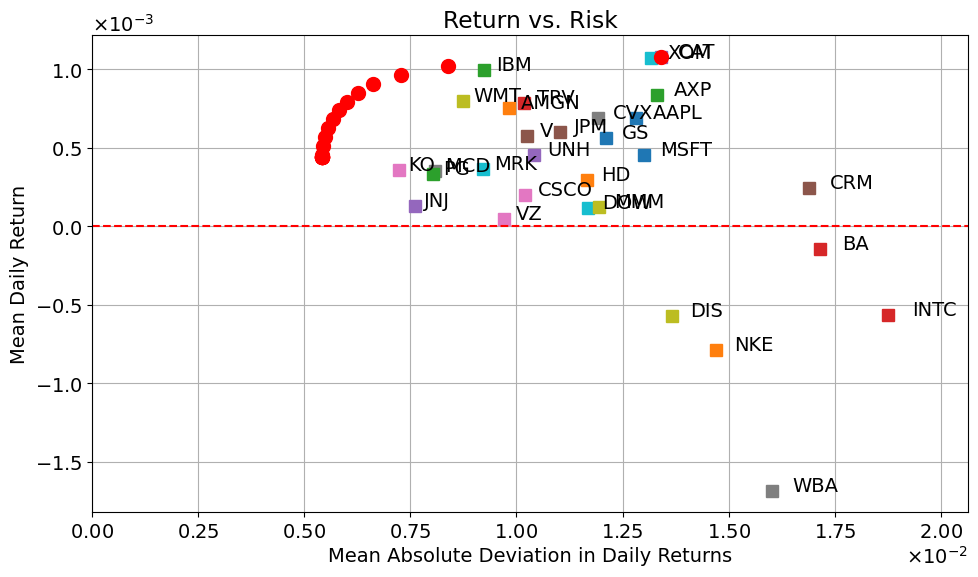

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
    ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

formatterx = mpl.ticker.ScalarFormatter(useMathText=True)
formatterx.set_scientific(True)
formatterx.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatterx)
formattery = mpl.ticker.ScalarFormatter(useMathText=True)
formattery.set_scientific(True)
formattery.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formattery)

ax.set_xlim(0, 1.1 * max(mean_absolute_deviation))
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Return vs. Risk")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

m = mad_portfolio(assets)
for R in np.linspace(0, mean_return.max(), 20):
    m.R = R
    SOLVER.solve(m)
    mad_portfolio_weights = pd.DataFrame(
        [m.w[a]() for a in sorted(m.ASSETS)], index=sorted(m.ASSETS)
    )

    portfolio_returns = daily_returns.dot(mad_portfolio_weights)
    portfolio_mean_return = portfolio_returns.mean()
    portfolio_mean_absolute_deviation = abs(
        portfolio_returns - portfolio_mean_return
    ).mean()
    ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, "ro", ms=10)

plt.tight_layout()
plt.show()

In [117]:
def mad_portfolio_withriskfreeasset(assets):
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    m = pyo.ConcreteModel()

    m.R = pyo.Param(mutable=True, default=0)
    m.rf = pyo.Param(mutable=True, default=0)
    m.w_lb = pyo.Param(mutable=True, default=0)
    m.w_ub = pyo.Param(mutable=True, default=1.0)

    m.ASSETS = pyo.Set(initialize=assets.columns)
    m.TIME = pyo.RangeSet(len(daily_returns.index))

    m.w = pyo.Var(m.ASSETS)
    m.u = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    m.v = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.minimize)
    def MAD(m):
        return sum(m.u[t] + m.v[t] for t in m.TIME) / len(m.TIME)

    @m.Constraint(m.TIME)
    def portfolio_returns(m, t):
        date = daily_returns.index[t - 1]
        return m.u[t] - m.v[t] == sum(
            m.w[j] * (daily_returns.loc[date, j] - mean_return[j]) for j in m.ASSETS
        )

    @m.Constraint()
    def sum_of_weights(m):
        return sum(m.w[j] for j in m.ASSETS) <= 1

    @m.Constraint()
    def mean_portfolio_return(m):
        return sum(m.w[j] * (mean_return[j] - m.rf) for j in m.ASSETS) >= m.R - m.rf

    @m.Constraint(m.ASSETS)
    def no_short(m, j):
        return m.w[j] >= m.w_lb

    @m.Constraint(m.ASSETS)
    def diversify(m, j):
        return m.w[j] <= m.w_ub

    return m

m = mad_portfolio_withriskfreeasset(assets)

m.w_lb = 0.001
m.w_ub = 0.4
m.R = 0.001

result = SOLVER.solve(m)
result

{'Problem': [{'Lower bound': 0.008463566707812715, 'Upper bound': 0.008463566707812715, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [118]:
print(f"Weight lower bound                 {m.w_lb():0.3f}")
print(f"Weight upper bound                 {m.w_ub():0.3f}")

Weight lower bound                 0.001
Weight upper bound                 0.400


In [119]:
weights = {j: round(m.w[j](), 3) if round(m.w[j](), 3) != 0 else 0 for j in m.ASSETS}
weights

{'AAPL': 0.001,
 'AMGN': 0.001,
 'AXP': 0.001,
 'BA': 0.001,
 'CAT': 0.178,
 'CRM': 0.001,
 'CSCO': 0.001,
 'CVX': 0.001,
 'DIS': 0.001,
 'DOW': 0.001,
 'GS': 0.001,
 'HD': 0.001,
 'IBM': 0.4,
 'INTC': 0.001,
 'JNJ': 0.001,
 'JPM': 0.001,
 'KO': 0.001,
 'MCD': 0.001,
 'MMM': 0.001,
 'MRK': 0.001,
 'MSFT': 0.001,
 'NKE': 0.001,
 'PG': 0.001,
 'TRV': 0.001,
 'UNH': 0.001,
 'V': 0.001,
 'VZ': 0.001,
 'WBA': 0.001,
 'WMT': 0.066,
 'XOM': 0.33}

In [120]:
print(f"Fraction of portfolio invested     {m.sum_of_weights():0.3f}")
print(f"Required portfolio daily return    {m.R():0.3f}")
print(f"Portfolio mean daily return        {m.mean_portfolio_return():0.3f}")
print(f"Portfolio mean absolute deviation  {m.MAD():0.5f}")

Fraction of portfolio invested     1.000
Required portfolio daily return    0.001
Portfolio mean daily return        0.001
Portfolio mean absolute deviation  0.00846


In [121]:
def gradient_barplot(ax, data, color_map):
    min_val = data.min()
    max_val = data.max()
    range_val = max_val - min_val

    for i, val in enumerate(data):
        normalized_val = (val - min_val) / range_val
        color = color_map(normalized_val)
        ax.barh(i, val, color=color)

def mad_visualization(assets, m):
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()
    mad_portfolio_weights = pd.DataFrame(
        [m.w[j]() for j in sorted(m.ASSETS)], index=sorted(m.ASSETS)
    )

    plt.rcParams["font.size"] = 14
    fig, ax = plt.subplots(1, 3, figsize=(15, 0.35 * len(daily_returns.columns)))

    # Choose the color maps
    color_map1 = plt.get_cmap("Greys")
    color_map2 = plt.get_cmap("coolwarm").reversed()
    color_map3 = plt.get_cmap("YlGn").reversed()

    # MAD Portfolio Optimal Weights
    gradient_barplot(ax[0], mad_portfolio_weights[0], color_map1)
    ax[0].set_title("Optimal weights of MAD portfolio")
    ax[0].set_yticks(np.arange(len(mad_portfolio_weights)))
    ax[0].set_yticklabels(mad_portfolio_weights.index)
    ax[0].axvline(m.w_lb(), ls="--", color="g")
    ax[0].axvline(m.w_ub(), ls="--", color="r")
    ax[0].legend(
        ["lower bound", "upper bound"], bbox_to_anchor=(0.97, 0), loc="lower right"
    )
    ax[0].set_xlim(-0.005, 0.21)

    # Asset mean daily return
    gradient_barplot(ax[1], mean_return, color_map2)
    ax[1].set_title("Asset mean daily return")
    ax[1].set_yticks(np.arange(len(mean_return)))
    ax[1].set_yticklabels(mean_return.index)
    ax[1].axvline(m.R(), ls="--", color="g")
    ax[1].axvline(m.mean_portfolio_return() + 0.000015, ls="--", color="r")
    ax[1].legend(
        ["required return", "portfolio return"],
        bbox_to_anchor=(1.01, 0),
        loc="lower right",
    )
    ax[1].set_xlim(-0.0005, 0.0028)

    # Formatter
    formatter = mpl.ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax[1].xaxis.set_major_formatter(formatter)

    # Asset mean absolute deviation
    gradient_barplot(ax[2], mean_absolute_deviation, color_map3)
    ax[2].set_title("Asset mean absolute deviation")
    ax[2].set_yticks(np.arange(len(mean_absolute_deviation)))
    ax[2].set_yticklabels(mean_absolute_deviation.index)
    ax[2].axvline(m.MAD(), ls="--", color="r")
    ax[2].legend(["portfolio MAD"], bbox_to_anchor=(1.01, 0), loc="lower right")

    # Formatter
    formatter = mpl.ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax[2].xaxis.set_major_formatter(formatter)
    ax[2].set_xlim(-0.001, 0.02)

    plt.tight_layout()
    plt.show()

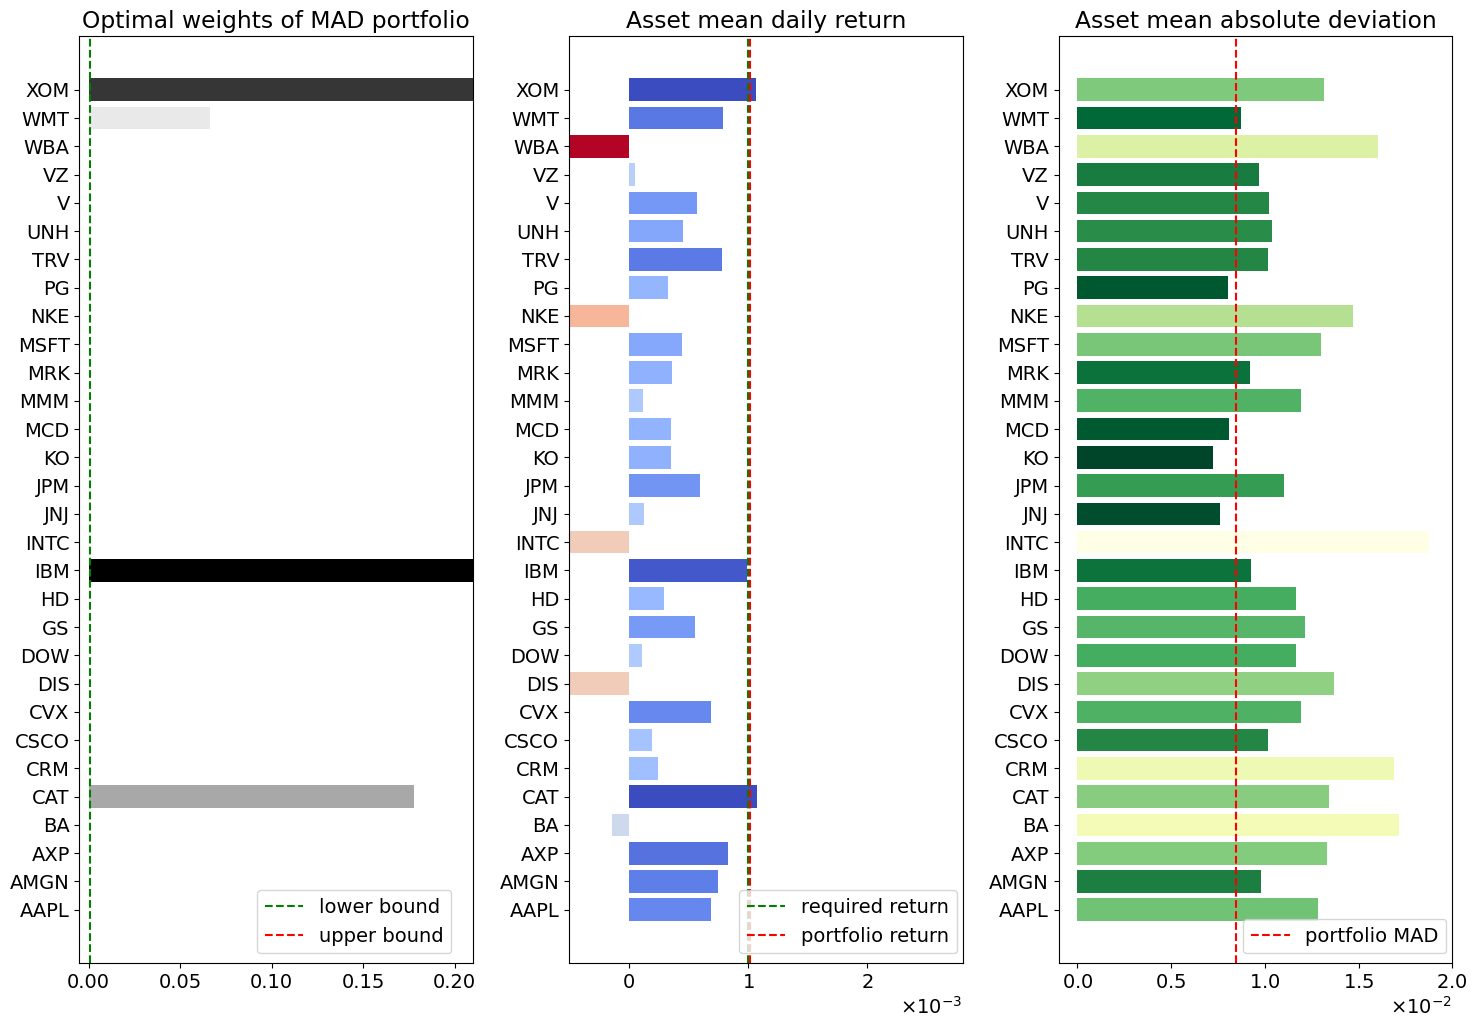

In [123]:
mad_visualization(assets, m)

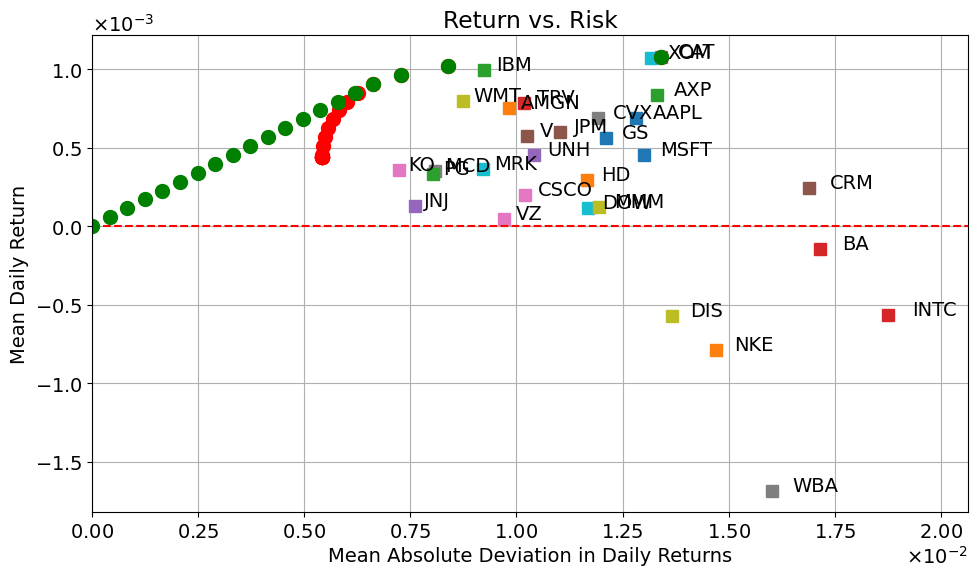

In [124]:
daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
    ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

formatterx = mpl.ticker.ScalarFormatter(useMathText=True)
formatterx.set_scientific(True)
formatterx.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatterx)
formattery = mpl.ticker.ScalarFormatter(useMathText=True)
formattery.set_scientific(True)
formattery.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formattery)

ax.set_xlim(0, 1.1 * max(mean_absolute_deviation))
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Return vs. Risk")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

for color, m in zip(
    ["ro", "go"], [mad_portfolio(assets), mad_portfolio_withriskfreeasset(assets)]
):
    for R in np.linspace(0, mean_return.max(), 20):
        m.R = R
        SOLVER.solve(m)
        mad_portfolio_weights = pd.DataFrame(
            [m.w[a]() for a in sorted(m.ASSETS)], index=sorted(m.ASSETS)
        )
        portfolio_returns = daily_returns.dot(mad_portfolio_weights)
        portfolio_mean_return = portfolio_returns.mean()
        portfolio_mean_absolute_deviation = abs(
            portfolio_returns - portfolio_mean_return
        ).mean()
        ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, color, ms=10)

plt.tight_layout()
plt.show()